# 1. Data Preprocessing
Before building the model, you need to prepare the data:

Load Tesla's stock data from YFinance and ensure that the 'Date' column is in datetime format.
Check for missing values and handle them (either interpolate, forward-fill, or drop).
Set the Date column as the index to ensure the time series is properly indexed.
Split the data into a training set and a test set, typically using 80% of the data for training and 20% for testing.

In [1]:
import yfinance as yf
import pandas as pd

# Fetch Tesla data
tsla = yf.download('TSLA', start='2015-01-01', end='2024-10-31')

# Ensure the data has no missing values (handle if needed)
tsla = tsla.dropna()

# Select 'Close' for the forecasting task
tsla = tsla['Close']

# Split data (80% train, 20% test)
train_size = int(len(tsla) * 0.8)
train, test = tsla[:train_size], tsla[train_size:]

# Check the head of the data to confirm it
print(tsla.head())


[*********************100%***********************]  1 of 1 completed

Ticker                          TSLA
Date                                
2015-01-02 00:00:00+00:00  14.620667
2015-01-05 00:00:00+00:00  14.006000
2015-01-06 00:00:00+00:00  14.085333
2015-01-07 00:00:00+00:00  14.063333
2015-01-08 00:00:00+00:00  14.041333


# 2. ARIMA Model
ARIMA (AutoRegressive Integrated Moving Average) is a classical statistical method suited for univariate time series with no seasonality.

Steps:
* Stationarity Check: Ensure that the data is stationary (i.e., no trends or seasonality).
* Differencing: Apply differencing to remove trends.
* Autocorrelation: Use the autocorrelation and partial autocorrelation functions (ACF/PACF) to determine the parameters 
𝑝, d, and 𝑞

* Train the ARIMA model using the optimal parameters.

ADF Statistic: -1.1507672706146033
p-value: 0.6944080657685308


c:\Users\MMM\Documents\10 Academy File\KAIM-Week-11\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MMM\Documents\10 Academy File\KAIM-Week-11\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MMM\Documents\10 Academy File\KAIM-Week-11\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MMM\Documents\10 Academy File\KAIM-Week-11\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported 

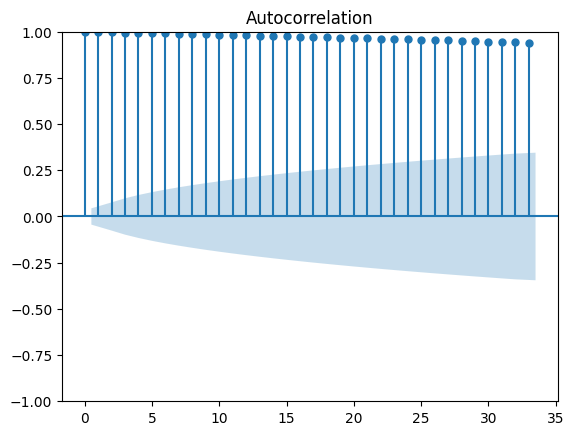

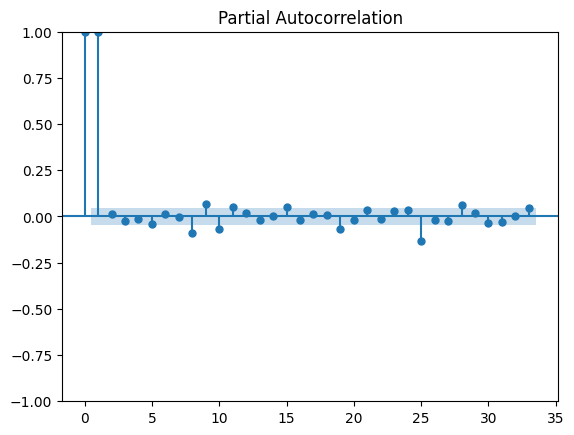

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Check for stationarity (ADF Test)
from statsmodels.tsa.stattools import adfuller
result = adfuller(tsla)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Plot ACF and PACF to determine p, d, q
plot_acf(train)
plot_pacf(train)

# Train ARIMA model with parameters (p, d, q)
model_arima = ARIMA(train, order=(5,1,0))  # Example values
model_arima_fit = model_arima.fit()

# Forecasting
forecast_arima = model_arima_fit.forecast(steps=len(test))


3. SARIMA Model
SARIMA extends ARIMA by incorporating seasonality, which is useful if there is periodic fluctuation in stock prices (e.g., monthly or yearly patterns).

Steps:
Seasonality: Use seasonal differencing and the seasonal components 
P, 𝐷,and Q.
SARIMA Model: Apply the SARIMA model with the determined parameters.

# 4. LSTM Model (Deep Learning Approach)
LSTM (Long Short-Term Memory) is a deep learning model that is capable of capturing long-term dependencies in time series data, making it suitable for predicting stock prices over longer horizons.

Steps:
* Data Transformation: Prepare the data by scaling it and reshaping it into a format suitable for LSTM (3D format: [samples, timesteps, features]).
* Model Building: Define and train the LSTM model.
* Train and Test: Train the model and predict future prices.

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Prepare data for LSTM (create sequences)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # 60 previous days to predict next day
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=1))  # Output layer
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

# Forecasting
predicted_prices = model_lstm.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Reverse scaling


c:\Users\MMM\Documents\10 Academy File\KAIM-Week-11\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - loss: 0.0190
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0011
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0010
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0011
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 7.2003e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 6.6911e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 6.5259e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 7.1135e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 6.2198e-04
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 5.7524e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step


# 5. Model Evaluation
For all models, you should evaluate their performance using these metrics:

* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE)
* Mean Absolute Percentage Error (MAPE)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(true_values, predicted_values):
    """
    Calculate MAE, RMSE, and MAPE for the model's predictions.
    
    Parameters:
    - true_values (pd.Series or np.array): Actual values from the test set.
    - predicted_values (pd.Series or np.array): Predicted values from the model.
    
    Returns:
    - dict: A dictionary containing MAE, RMSE, and MAPE.
    """
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

    # Print the results
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# Example usage:
# Assuming `test` is your test set and `forecast` is the predicted series.
# evaluate_model(test['Close'], forecast)


# 6. Model Optimization
* Grid Search: Use techniques like GridSearchCV for hyperparameter tuning of ARIMA, or Keras Tuner for LSTM models.
* AutoARIMA: Use the auto_arima function from the pmdarima library to automatically find the best (p, d, q) parameters for ARIMA.
